# Implementação Centroide


In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

ds = pd.read_csv('dataset/iris.csv')

ds.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Funções auxiliares
- Euclidian distance

In [2]:
def euclidian_distance(tuple_one, tuple_two):
    ed = 0
    
    for t1, t2 in zip(tuple_one, tuple_two):
        ed += (t1-t2) ** 2
    return np.sqrt(ed)

### Variaveis auxiliares

In [3]:
last_col = ds.columns[len(ds.columns)-1]
classes = list(ds[last_col].unique())

### Implementação do Centroide

Para a criação dos dados, interajo 30 vezes e para cada interação, utilizando uma variavel de controle ``i`` da primeira interação, para cada interação utilizo algoritmo centroide que varia entre 20% até 80%.
Assim eu consigo montar 2 datasets, um de treino e outro para teste.
Para cada interação, ele vai reordenando o dataset de maneira aleatória (pandas já faz isso automaticamente) para treinar e para testar.

In [4]:
def centroid (dataset, value):
    centroids = [] # (x,y,z,w)
    #Cria os centroides de cada classe
    for c in classes:
        # Faz um filtro para bsucar apenas linhas de uma determinada classe
        nds = dataset[dataset[last_col]==c]
        t_class = []
        
        # nds.values retorna o dataset inteiro como uma matriz ´´Array x Array´´
        # Função ´´np.transpose´´ retorna a transposta daquela matriz (exatamente igual a matematica)
        transpos = np.transpose(nds.values)[:-1] # ´´[:-1]´´ retira o ultimo array da lista, que é equivalente a coluna da classe 
        for col in transpos:
            t_class.append(col.mean())
        centroids.append(tuple(t_class))
    # Calcula a distancia euclidiana do valor passado até todos os centroides e coloca no seguinte formato de tupla
    dist = [(euclidian_distance(value,cent),cent, classes[i]) for i,cent in enumerate(centroids)]# Formato: (distance, centroid, class)
    resp = min(dist, key=lambda x: x[0])[2] # Pega o menor valor da distancia e seleciona apenas o nome da classe.
    return resp
            
        

#### Treinar
Executa o centroide e faz as contagens de erros e acertos

In [5]:
def train(dataset_train, dataset_test):
    count_correct = 0
    count_incorrect = 0
    
    count_by_classes_correct = [0 for i in range(0,len(classes))]
    count_by_classes_incorrect = [0 for i in range(0,len(classes))]
    
    for index, row in dataset_test.iterrows():
        
        tuple_t = list(row)
        tuple_t.pop()
        result = centroid(dataset_train,tuple(tuple_t))
        

        #Result
        if result == row[last_col]:
            count_correct += 1
            count_by_classes_correct[classes.index(result)] += 1
        else:
            count_incorrect += 1
            count_by_classes_incorrect[classes.index(result)] += 1
        
    return (count_correct, count_incorrect, count_by_classes_correct, count_by_classes_incorrect)

#### Separar dataset por classes
Essa função pega o dataset, separa por classe e divide em teste e treino de acordo com a porcentagem.
No final concatena datasets de treinos e testes.

In [6]:
def seperate_ds_by_class(dataset, percentage):
    rds_train = pd.DataFrame()
    rds_test = pd.DataFrame()
    
    for c in classes:
        nds = ds[ds[last_col]==c]
        
        # Essa função pega o dataset e separa uma fração dele, e reordena
        ds_train = nds.sample(frac=percentage, random_state=randint(0,15100))
        # Pega o que sobrou do dataset de treino
        ds_test = nds.drop(ds_train.index) 
        
        rds_train = rds_train.append(ds_train)
        rds_test = rds_test.append(ds_test)
        
    rds_train = rds_train.reset_index() # Reiniciar indice
    rds_test = rds_test.reset_index() # Reiniciar indice

    rds_train.drop('index',1,inplace=True) # Retirar coluna index
    rds_test.drop('index',1,inplace=True) # Retirar coluna index
    
    return (rds_train, rds_test)

#### Treinar e Testar
O algoritmo para implementar o K-NN, foi utilizando interando todos o dataset de ``teste`` e fazendo K-NN pela formula euclidiana e pegando o k-esimo ponto mais próximo para decidir qual a classe.
Com o resultado desse dado eu faço a verificação com cada dataset de teste da interação

In [7]:
def run_nth(percentage, number):
    percentages_correct = list()
    prob_correct_by_class = []
    
    for i in range(0,number):
        ds_train, ds_test = seperate_ds_by_class(ds,percentage)
        correct, incorrect, count_by_classes_correct, count_by_classes_incorrect = train(ds_train, ds_test)

        by_class = []
        for count_correct, count_incorrect in zip(count_by_classes_correct, count_by_classes_incorrect):
            if count_correct+count_incorrect != 0:
                by_class.append(count_correct/(count_correct+count_incorrect))
            else:
                by_class.append(0)
                
        prob_correct_by_class.append(by_class)
        percentages_correct.append(correct/(correct+incorrect))
        
    return (percentages_correct, prob_correct_by_class)

### Trata o resultado do treino e teste
Faz o calculo da porcentagem de acordo com a quantidade de corretas e incorretas

In [8]:
percents, prob_by_class = run_nth(0.7,30)

### Taxa de Acerto

In [9]:
taxa_acerto_min=np.min(percents)
taxa_acerto_max=np.max(percents)
taxa_acerto_med=np.mean(percents)

print('Taxa de Acerto')
print('--------------')
print('Minimo: ' + str(taxa_acerto_min))
print('Máxima: ' + str(taxa_acerto_max))
print('Média: '+str(taxa_acerto_med))

Taxa de Acerto
--------------
Minimo: 0.8222222222222222
Máxima: 0.9777777777777777
Média: 0.9162962962962964


### Taxa de Acerto Médio por Classe

In [10]:
print('Taxa de Acerto Médio por classe')
print('-------------------------------')

ar_value = [ np.mean(m) for m in np.array(prob_by_class).transpose() ]

for i, _class in enumerate(ar_value):
    print('Classe \'' +  classes[i] +'\' : ' + str(_class))

Taxa de Acerto Médio por classe
-------------------------------
Classe 'setosa' : 1.0
Classe 'versicolor' : 0.8574983767783942
Classe 'virginica' : 0.9149853958677489


### Produzir os dados para gerar o gráfico
Nessa parte ele interaje de **80/20** até **20/80** os datasets de treino e teste, a cada porcentagem ele calcula as medias de probabilidade de acerto 30 vezes.

**OBS: ESSE TRECHO DEMORA CERCA DE 3 minutos para executar.**

In [11]:
mean_percents = list()
percents_axis = list()
for n in range(20,81):
    p, pi = run_nth(n/100, 30)
    mean_percents.append(np.mean(p))
    percents_axis.append(n)
    

### Gráfico de acerto
Gráfico contendo a ``Probabilidade de acerto X Porcentagem do dataset de treino``.


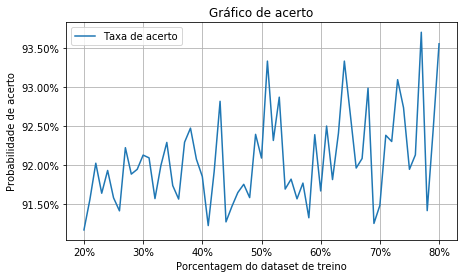

In [12]:
fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)
percents_axis = [x / 100 for x in percents_axis]
ax.plot(percents_axis, mean_percents, label='Taxa de acerto')
ax.set_title('Gráfico de acerto')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Probabilidade de acerto')

ax.set_xlabel('Porcentagem do dataset de treino')

plt.grid(True)
plt.legend()
plt.show()

Para cada porcentagem do dataset de treino, o restante dos dados foram utilizado para teste.
Por exemplo, caso eu tenha usado 20% para treino, 80% foram utilizado para teste (Não está explicito no gráfico)

### Gráfico de dispersão
Gráfico de dispersão e historgramas de elemento x elemento do dataset IRIS.


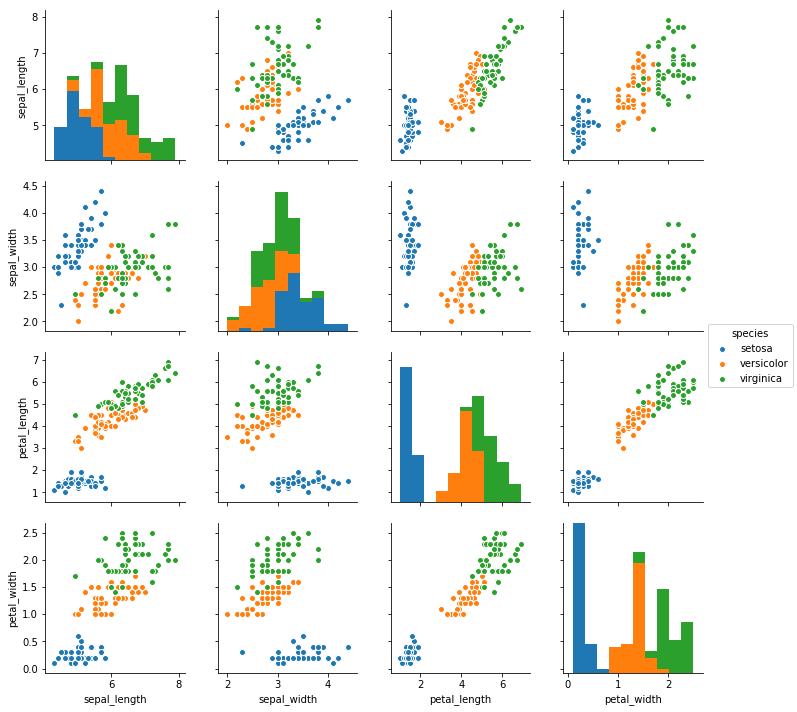

In [13]:
sns.pairplot(ds,hue='species')